In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import SDEFactory
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.plotting import plot_sample_path
from neuralbridge.utils.sample_path import SamplePath
from neuralbridge.utils.t_grid import TimeGrid

### Conditioning on normal event

#### Neural bridge

In [3]:
config = read_config("../configs/fhn_normal.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=30,
    training=False
)

{'sde': {'name': 'fhn', 'X_dim': 2, 'W_dim': 2, 'T': 2.0, 'dt': 0.005, 't_scheme': 'linear', 'params_X_unc': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3}, 'params_X_aux': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3, 'v': -1.0}, 'u': [-0.5, -0.6], 'v': [-1.0, nan], 'eps': 0.0001}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'fhn_normal_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.0005, 'batch_size': 30, 'n_iters_per_epoch': 500, 'n_epochs': 15, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.05, 'clip_norm': 1.0}, 'mcmc': {'n_chains': 10, 'eta': 0.0, 'n_iters': 50000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/fhn_normal_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


#### Pre-conditioned Crank-Nicolson

In [12]:
config = read_config("../configs/fhn_normal.yaml")

config.mcmc.n_chains = 30
pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
_, pcn_result = pcn_model.run()
X_pcn_path = pcn_result.path

Running pCN: 100%|██████████| 50000/50000 [01:28<00:00, 566.22it/s]
INFO:root:Batch average acceptance rate: 61.08%


#### Brutal force sampling to obtain the "ground truth"

In [8]:
X_unc_solver = Euler(X_unc, W, tGrid)
X_unc_path = X_unc_solver.solve(
    x0=u, 
    batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_unc_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_unc_path.xs[:, -1, 0] <= v[0] + 1e-2)
final_mask = x1_mask
X_cond_path = X_unc_path[final_mask]
print(f"Found {X_cond_path.n_samples} samples that satisfy the endpoint conditions out of {X_unc_path.n_samples} samples")

Found 4814 samples that satisfy the endpoint conditions out of 100000 samples


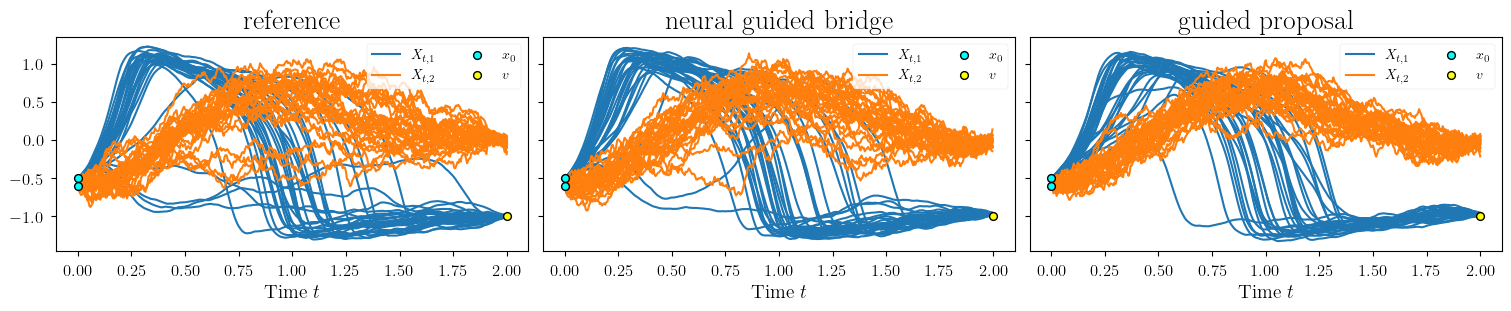

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), layout="constrained", sharex=True, sharey=True)

plot_sample_path(
    X_cond_path[:30], 
    ax=axes[0], 
    labels=[r"$X_{t, 1}$", r"$X_{t, 2}$"], 
    line_plot_kwargs={"linewidth": 1.5, "zorder": 2}
)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
axes[0].scatter(2.0, v[0], color="yellow", marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"Time $t$", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(ncol=2, fontsize=10)
axes[0].set_title(r"reference", fontsize=20)

plot_sample_path(
    X_neu_path[:30], 
    ax=axes[1], 
    labels=[r"$X_{t, 1}$", r"$X_{t, 2}$"], 
    line_plot_kwargs={"linewidth": 1.5, "zorder": 2}
)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
axes[1].scatter(2.0, v[0], color="yellow", marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"Time $t$", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(ncol=2, fontsize=10)
axes[1].set_title(r"neural guided bridge", fontsize=20)
plot_sample_path(
    X_pcn_path[:30], 
    ax=axes[2], 
    labels=[r"$X_{t, 1}$", r"$X_{t, 2}$"], 
    line_plot_kwargs={"linewidth": 1.5, "zorder": 2}
)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
axes[2].scatter(2.0, v[0], color="yellow", marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"Time $t$", fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].legend(ncol=2, fontsize=10)
axes[2].set_title(r"guided proposal", fontsize=20)
fig.savefig("../assets/figures/fhn_model/normal_results.pdf", dpi=300, bbox_inches="tight")
plt.show()

### Conditioning on extreme event

#### Neural bridge

In [16]:
config = read_config("../configs/fhn_extreme.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=30,
    training=False
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/fhn_extreme_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'fhn', 'X_dim': 2, 'W_dim': 2, 'T': 2.0, 'dt': 0.005, 't_scheme': 'linear', 'params_X_unc': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3}, 'params_X_aux': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3, 'v': 1.1}, 'u': [-0.5, -0.6], 'v': [1.1, nan], 'eps': 0.0001}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'fhn_extreme_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.0005, 'batch_size': 30, 'n_iters_per_epoch': 500, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}, 'mcmc': {'n_chains': 10, 'eta': 0.9, 'n_iters': 50000}}


#### Pre-conditioned Crank-Nicolson

In [19]:
config = read_config("../configs/fhn_extreme.yaml")

config.mcmc.n_chains = 30
config.mcmc.eta = 0.95
pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
_, pcn_result = pcn_model.run()
X_pcn_path = pcn_result.path

Running pCN: 100%|██████████| 50000/50000 [01:29<00:00, 559.28it/s]
INFO:root:Batch average acceptance rate: 1.40%


#### Brutal force sampling to obtain the "ground truth"

In [20]:
X_unc_solver = Euler(X_unc, W, tGrid)
X_unc_path = X_unc_solver.solve(
    x0=u, 
    batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_unc_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_unc_path.xs[:, -1, 0] <= v[0] + 1e-2)
final_mask = x1_mask
X_cond_path = X_unc_path[final_mask]
print(f"Found {X_cond_path.n_samples} samples that satisfy the endpoint conditions out of {X_unc_path.n_samples} samples")

Found 108 samples that satisfy the endpoint conditions out of 100000 samples


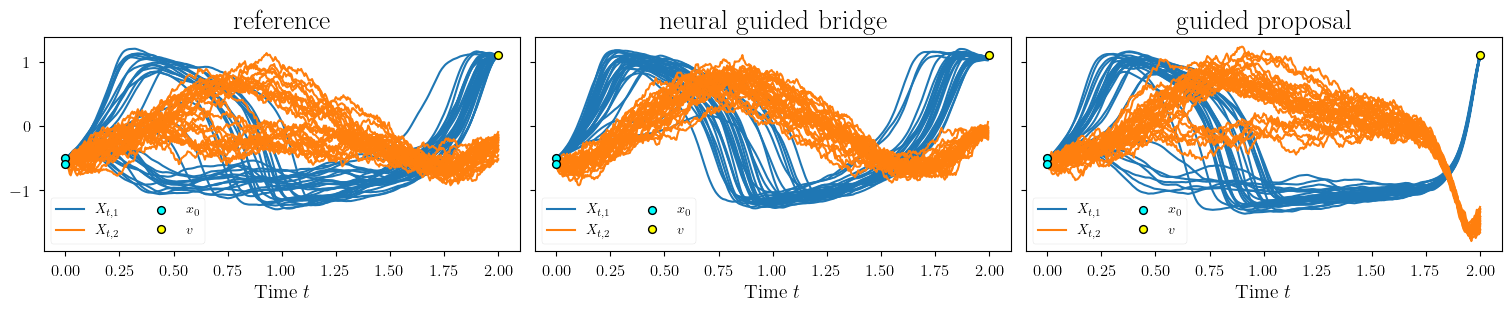

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), layout="constrained", sharex=True, sharey=True)

plot_sample_path(
    X_cond_path[:30], 
    ax=axes[0], 
    labels=[r"$X_{t, 1}$", r"$X_{t, 2}$"], 
    line_plot_kwargs={"linewidth": 1.5, "zorder": 2}
)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
axes[0].scatter(2.0, v[0], color="yellow", marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"Time $t$", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(ncol=2, fontsize=10)
axes[0].set_title(r"reference", fontsize=20)

plot_sample_path(
    X_neu_path[:30], 
    ax=axes[1], 
    labels=[r"$X_{t, 1}$", r"$X_{t, 2}$"], 
    line_plot_kwargs={"linewidth": 1.5, "zorder": 2}
)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
axes[1].scatter(2.0, v[0], color="yellow", marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"Time $t$", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(ncol=2, fontsize=10)
axes[1].set_title(r"neural guided bridge", fontsize=20)
plot_sample_path(
    X_pcn_path[:30], 
    ax=axes[2], 
    labels=[r"$X_{t, 1}$", r"$X_{t, 2}$"], 
    line_plot_kwargs={"linewidth": 1.5, "zorder": 2}
)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
axes[2].scatter(2.0, v[0], color="yellow", marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"Time $t$", fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].legend(ncol=2, fontsize=10)
axes[2].set_title(r"guided proposal", fontsize=20)
fig.savefig("../assets/figures/fhn_model/extreme_results.pdf", dpi=300, bbox_inches="tight")
plt.show()